In [1]:
%matplotlib notebook
import numpy as np
import pickle as pk
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# with open('/workspaces/pyskl/work_dirs/stgcn_ntu60_coco_1/last_pred.pkl', 'rb') as f:
#     pred = pk.load(f)
# # print(len(context))

ensemble_num = 4
pred_ensemble = []
for idx in range(ensemble_num):
    with open(f'/workspaces/pyskl/work_dirs/stgcn_ntu60_coco_{idx+1}/last_pred.pkl', 'rb') as f:
        pred = pk.load(f)
    pred_ensemble.append(pred)

In [3]:
with open('/workspaces/pyskl/data_generate/datasets_ntu60/ntu60_hrnet.pkl', 'rb') as f:
    gt = pk.load(f)
print(gt.keys())

true_num_ = 0
true_num = 0
true_uncert = []
false_uncert = []
for idx, item in enumerate(gt['split']['xsub_val']):
    
    # 根据gt中sub_val的划分，获取真值
    for i in gt['annotations']:
#         print(i['frame_dir'])
        if item == i['frame_dir']:
            gt_label = i['label']
            break
            
    all = np.concatenate(
        ([pred_ensemble[i][idx][np.newaxis,...] for i in range(ensemble_num)]),
        axis = 0
    )
        
    # disagreement / uncertainty
    uncertainty = 0
    pred_mean = np.mean(all, axis=0)
    for each in all:
        uncertainty += np.sum(each * (np.log(each+1e-20) - np.log(pred_mean+1e-20)))
        
    # 单个模型的预测结果
    pred = all[0]
    pred_label = np.argmax(pred)
    if gt_label == pred_label:
        true_num += 1
    
    # 集成模型的预测结果
    pred_ = np.mean(all, axis=0)
    pred_label_ = np.argmax(pred_)
    if gt_label == pred_label_:
        true_num_ += 1
        true_uncert.append(uncertainty)
    else:
        false_uncert.append(uncertainty)


test_num = len(gt['split']['xsub_val'])
print(true_num/test_num)
print(true_num_/test_num)

dict_keys(['split', 'annotations'])
0.8743858797840723
0.8967671498756596


<IPython.core.display.Javascript object>


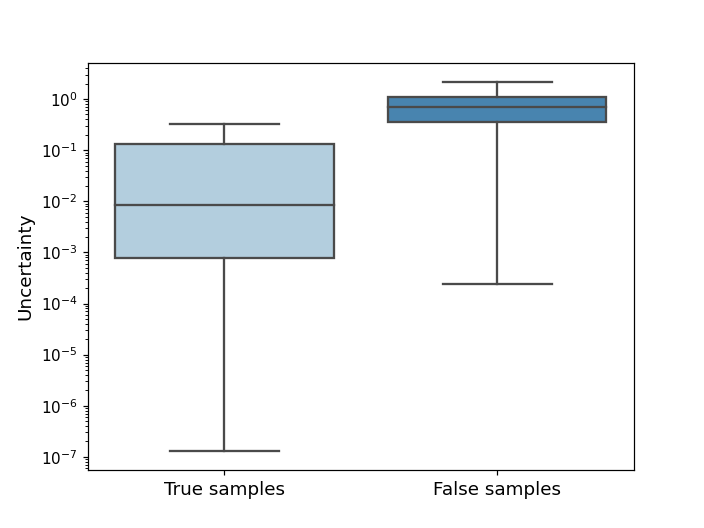

In [4]:
false_uncert = list(itertools.islice(itertools.cycle(false_uncert), len(true_uncert)))

df = pd.DataFrame({'True samples': true_uncert, 'False samples': false_uncert})
# df.head()
sns.boxplot(data=df, dodge=False, showfliers=False, palette="Blues")
plt.yscale('log')
plt.ylabel('Uncertainty', fontsize=12)
# plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=12)
plt.show()
plt.savefig(r'/workspaces/pyskl/workspace/notebooks/compares.svg', bbox_inches = 'tight')

In [2]:
with open('/workspaces/pyskl/demo/results/demo_uncertainty.pkl', 'rb') as f:
    context = pk.load(f)
print(context.keys())

dict_keys(['predictions', 'uncertainties'])


<IPython.core.display.Javascript object>


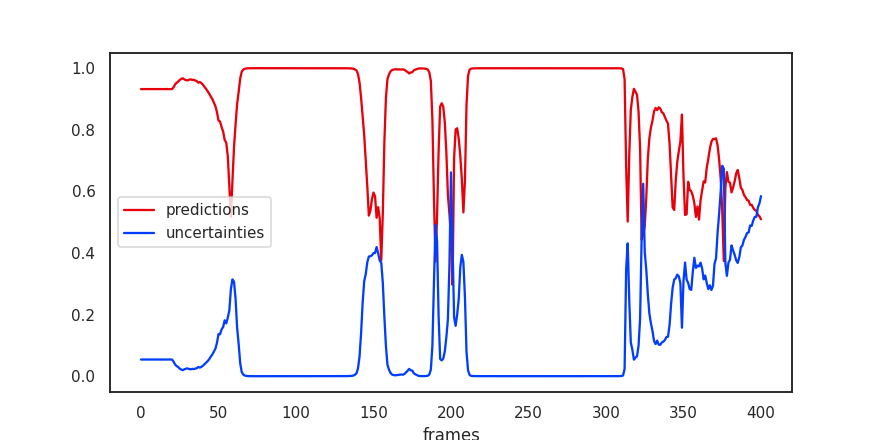

In [16]:
iters = [it for it in range(len(context['predictions']))]

predictions = context['predictions']
uncertainties = 1/4 * np.array(context['uncertainties'])
# print(predictions)

plt.figure(figsize=(8, 4))  # Set the figure size
sns.set(style="white", font_scale=0.9)  # Set the style
# {deep, muted, pastel, dark, bright, colorblind}
sns.set_color_codes(palette='bright')
plt.xlabel('frames')
# plt.title('Loss', fontsize=12)
# plt.tick_params(pad = 0.00)

sns.lineplot(x=iters, y=predictions, linestyle="-", color='r', label="predictions")
sns.lineplot(x=iters, y=uncertainties, linestyle="-", color='b', label="uncertainties")
plt.show()

# plt.savefig('/workspaces/pyskl/workspace/notebook/Loss.svg', bbox_inches = 'tight')